In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
    
### Custom code
helpers = os.path.abspath('../../../Helpers')
if helpers not in sys.path:
    sys.path.append(helpers)
from utils import (
    mkdir_p,
)
from gammapy_ogip.ogip_spectrum_dataset import StandardOGIPDataset

from gammapy.modeling.models import (
    SkyModel,
    Models,
    PowerLawSpectralModel,
)
from gammapy.datasets import Datasets

from scipy.ndimage import gaussian_filter
from regions import CircleSkyRegion
from astropy import units as u 
from astropy.io import fits as pyfits
from astropy.visualization import AsinhStretch, PercentileInterval
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord


In [2]:
def prepare_dataset(phafile,name='OGIP',bkgfile=None,arffile=None,rmffile=None,rebin_factor=1,energy_bins=None):
    if [bkgfile,arffile,rmffile] != None:
        with pyfits.open(phafile, mode='update') as hdul:
            if bkgfile is not None:
                hdul[1].header['BACKFILE'] = bkgfile
            if arffile is not None:
                hdul[1].header['ANCRFILE'] = arffile
            if rmffile is not None:
                hdul[1].header['RESPFILE'] = rmffile
                
    MyOGIP = StandardOGIPDataset.read(phafile)
    SDataset = MyOGIP.to_spectrum_dataset_onoff(name=name)
    
    # Resample datasets. Swift-XRT start their edisp from E=0 keV, 
    # we need to discard that first problematic bin, otherwise the log-space evaluation in gammapy fails.
    emin = SDataset.counts.geom.axes['energy'].edges[0]
    emax = SDataset.counts.geom.axes['energy'].edges[-1]

    if energy_bins is None:
        energy_bins = len(SDataset.counts.geom.axes['energy'].edges)-1

    lin_bins = np.linspace(emin.value,emax.value,int(energy_bins*1./rebin_factor)+1)[1:]
    new_binning = np.asarray(lin_bins)*u.keV
    new_eaxis = SDataset.counts.geom.axes['energy'].from_edges(new_binning,name='energy')
    
    SDataset_rebinned = SDataset.copy(name='Swift-XRT')
    SDataset_rebinned.acceptance      = SDataset.acceptance.resample_axis(new_eaxis)
    SDataset_rebinned.acceptance_off  = SDataset.acceptance_off.resample_axis(new_eaxis)
    SDataset_rebinned.counts          = SDataset_rebinned.counts.resample_axis(new_eaxis)
    SDataset_rebinned.counts_off      = SDataset_rebinned.counts_off.resample_axis(new_eaxis)
    SDataset_rebinned.edisp           = SDataset_rebinned.edisp.resample_energy_axis(new_eaxis)
    SDataset_rebinned.mask_safe       = SDataset_rebinned.counts.geom.energy_mask(0.2*u.keV, 12*u.keV)
    SDataset_rebinned.mask_fit        = SDataset_rebinned.counts.geom.energy_mask(0.2*u.keV, 12*u.keV)

    SDataset_rebinned._name = name
    SDataset_rebinned.meta_table = None
    return({'phafile':phafile, 'wstat': SDataset_rebinned})


SwiftXRT = prepare_dataset(
    phafile="/mnt/sdb1/Swift/OP313/reproc/00036384074/XRT/events/sw_sum_spectra_po_cl.pha",
    bkgfile="/mnt/sdb1/Swift/OP313/reproc/00036384074/XRT/events/sw_sum_spectra_background_po_cl.pha",
    arffile="/mnt/sdb1/Swift/OP313/reproc/00036384074/XRT/events/sw_sum_spectra_po_cl.arf",
    rmffile="/mnt/sdb1/Swift/OP313/reproc/00036384074/XRT/events/swxpc0to12s6_20210101v016.rmf",
    name="Swift_XRT",
    rebin_factor=30,
)

SwiftXRT_wstat = SwiftXRT['wstat']

/home/mnievas/anaconda/envs/ciaoxray_devel/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [3]:
### Sky models
def get_1d_pwl_skymodel(name):
    s = PowerLawSpectralModel()
    s.reference.value = 1
    s.reference.unit  = 'keV'
    s.amplitude.value = 1e-3
    s.amplitude.unit = 'keV-1 s-1 cm-2'
    s.amplitude.min  = 1e-9
    s.amplitude.max  = 1e6
    s.index.value = 2
    s.index.min  = -2.0
    s.index.max  = 8.0
    skymodel = SkyModel(name=name, spectral_model=s)
    return(skymodel)

# Source (pwl)
OP313_SkyModel = get_1d_pwl_skymodel(name='OP313')

### Full model, with instrumental background
SwiftXRT_wstat.models = Models([OP313_SkyModel])

In [4]:
# Save and compress the datasets
basedir = os.path.abspath("../../../")
outdir  = f"{basedir}/XRT/MJD60373/"
mkdir_p(outdir)
for g in glob.glob(f"{outdir}/*.yaml*"): os.remove(g)
for g in glob.glob(f"{outdir}/*.fits*"): os.remove(g)

SwiftXRT_datasets = Datasets([SwiftXRT_wstat])

SwiftXRT_datasets.write(filename=f"{outdir}/dataset.yaml",
                        filename_models=f"{outdir}/models.yaml",
                        write_covariance=False,
                        overwrite=True)

#!gzip {outdir}/*.fits
#!sed -i 's/.fits/.fits.gz/g' {outdir}/dataset.yaml

## Dataset representation

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 60373.268657 from DATE-END'. [astropy.wcs.wcs]


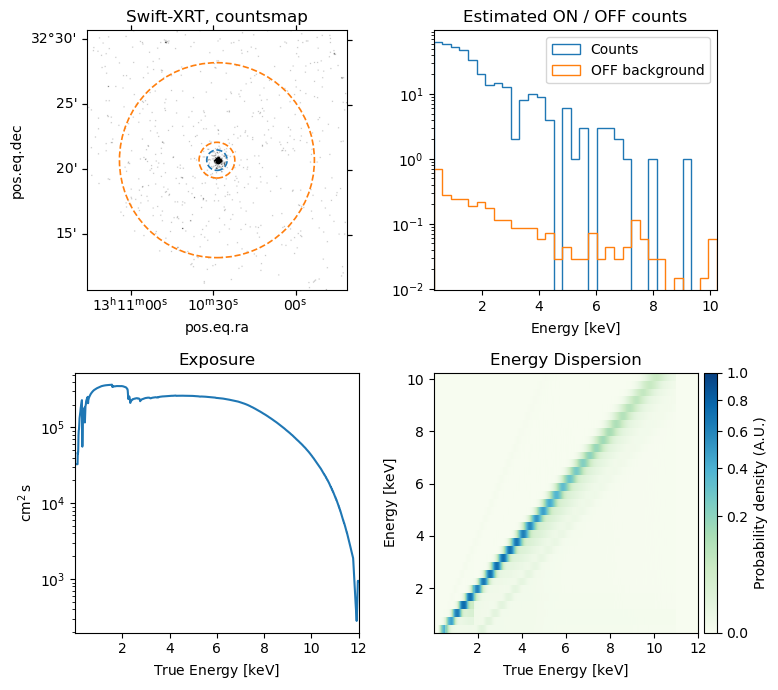

In [6]:
fig, axs = plt.subplots(2,2,figsize=(8,7))

hdu_first = pyfits.open('/mnt/sdb1/Swift/OP313/old/obs/00036384074/xrt/products/sw00036384074xpc_sk.img.gz')

#transform = AsinhStretch() + PercentileInterval(99.975)
transform = AsinhStretch() + PercentileInterval(99.975)

cutoutdata = Cutout2D(hdu_first[0].data, position=SkyCoord.from_name('OP313'), size=20*u.arcmin, wcs=WCS(hdu_first[0]))

axs[0][0].remove()

ax = fig.add_subplot(221, projection=cutoutdata.wcs)#
#ax.imshow(gaussian_filter(transform(cutoutdata.data)**(1./4),0),cmap='Greys')
ax.imshow(transform(gaussian_filter(cutoutdata.data**(0.95),0.75)),cmap='Greys',vmax=0.5)
ax.coords['ra'].set_ticks(number=3,direction='out')


r = CircleSkyRegion(center=SkyCoord.from_name('OP313'),radius=47.146*u.arcsec)
r.to_pixel(cutoutdata.wcs).plot(lw=1.2,color='C0',ls='dashed',label='Source region')

rin = CircleSkyRegion(center=SkyCoord.from_name('OP313'),radius=82.506*u.arcsec)
rout = CircleSkyRegion(center=SkyCoord.from_name('OP313'),radius=212.158*u.arcsec)
rout = CircleSkyRegion(center=SkyCoord.from_name('OP313'),radius=450*u.arcsec)

rin.to_pixel(cutoutdata.wcs).plot(lw=1.2,color='C1',ls='dashed',label='Source region')
rout.to_pixel(cutoutdata.wcs).plot(lw=1.2,color='C1',ls='dashed',label='Source region')

ax.set_title('Swift-XRT, countsmap')
#ax.set_ylabel('Declination [dms]')
#ax.set_xlabel('Right ascension [hms]')
ax.set_box_aspect(1)

axs[0][1].set_title("Estimated ON / OFF counts")
SwiftXRT_wstat.plot_counts(axs[0][1], kwargs_background={'label': 'OFF background'})
#NuSTAR_A_src.plot_masks(ax=axs[0][1])
axs[0][1].legend()


axs[1][0].set_title("Exposure")
SwiftXRT_wstat.exposure.plot(axs[1][0], ls="-", markersize=0, xerr=None)

axs[1][1].set_title("Energy Dispersion")

if SwiftXRT_wstat.edisp is not None:
    kernel = SwiftXRT_wstat.edisp.get_edisp_kernel()
    kernel.plot_matrix(ax=axs[1][1], add_cbar=True)

axs[1][1].set_rasterized(True)
plt.tight_layout()

!mkdir -p {basedir}/Figures/MJD60373/Swift-XRT/
fig.savefig(f'{basedir}/Figures/MJD60373/Swift-XRT/SwiftXRT_rebinned_IRFs.pdf')